# Genetic algorithm-based heuristic for feature selection in credit risk assessment

## Questions :

### The Search Space Reduction 

* Means of the filter techniques for feature ranking: Information gain, Gain ratio,Gini index and Correlation => How we should create initial Chromosomes exactly ?
* How we should Initialize initial population ?
* What is Feature Ranking Exactly ? 
* What tik of essay means ?
* what it means by p_initial, i think it means other part of initial population

## Explanation
* First Hypothesis: We should first find reduce features to reduce features subset, then we should create initial_population based on this features.
* Second Hypothesis: We should Initial our first population just from reduced feature subset.
* Third Hypothesis: If We Initialized Chromosomes from reduced features subset and we couldn't reach minimum of features then we fill remainder by features that are not included in reduced feature subset

First we import libraries ,we will be needed through this notebook : 

In [219]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from numpy.random import rand as random
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input

## Reduced Features Configurations

In [2]:
reduced_feature_config = {
    'IG': [ 0,  1,  2,  6,  9, 10, 11, 19, 20, 21, 22, 24],
    'gain_ratio': [ 0,  1,  2,  4,  9, 10, 19, 20, 21, 22, 24, 29],
    'correlation': [ 0,  1,  2,  4,  6,  9, 10, 11, 19, 20, 22, 24],
    'voting': [ 0,  1,  2,  9, 10, 19, 20, 22, 24],
    'current_solution': [ 0,  1,  2,  3, 10, 12, 13, 14, 17, 19, 20, 27, 29]
}

## Calculating Union Of reduced_feature_config And every feature rank

In [3]:
reduced_feature_subset = []
for key in reduced_feature_config : 
    reduced_feature_subset += reduced_feature_config[key]
reduced_feature_subset_rank = {}
for feature in reduced_feature_subset:
    if feature in reduced_feature_subset_rank:
        reduced_feature_subset_rank[feature] += 1
    else :
        reduced_feature_subset_rank[feature] = 1
reduced_feature_subset = sorted(list(set(reduced_feature_subset)))

## Configes

In [44]:
genetic_config = { 
    'maxFeatureNum': 12,
    'minFeatureNum': 5,
    'popSize': 50,
    'trueProb': .5,
    'cProb': .9,
    'mProb': .01,
    'generationNum': 50,
    'tPressure': .1,
    'genNum': 0  
}
nn_config = {
    'lr': np.random.uniform(0.3, 1.0),
    'trainCycles': np.random.uniform(300, 600),
    'm': np.random.uniform(0.2, 0.7)
}

## Address Of Datasets 

In [149]:
data_root = 'data'
german_data =os.path.join(data_root,'GermanCreditInput.xls')
german_label = os.path.join(data_root,'GermanCreditOutputClass1columnknn.xls')
australian_dataset = os.path.join(data_root,'australian dataset.xlsx')
x_train = pd.read_excel(german_data,header=None)
y_train = pd.read_excel(german_label,header=None)
x_train.iloc[np.full(30,True)]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,6,4,0,0,0,1,0,0,1169,...,0,67,0,0,1,2,2,1,1,0
1,1,48,2,0,0,0,1,0,0,5951,...,0,22,0,0,1,1,2,1,0,0
2,3,12,4,0,0,0,0,1,0,2096,...,0,49,0,0,1,1,1,2,0,0
3,0,42,2,0,0,1,0,0,0,7882,...,0,45,0,0,0,1,2,2,0,0
4,0,24,3,1,0,0,0,0,0,4870,...,1,53,0,0,0,2,2,2,0,0
5,3,36,2,0,0,0,0,1,0,9055,...,1,35,0,0,0,1,1,2,1,0
6,3,24,2,0,0,1,0,0,0,2835,...,0,53,0,0,1,1,2,1,0,0
7,1,36,2,0,1,0,0,0,0,6948,...,0,35,0,1,0,1,3,1,1,0
8,3,12,2,0,0,0,1,0,0,3059,...,0,61,0,0,1,1,1,1,0,0
9,1,30,4,1,0,0,0,0,0,5234,...,0,28,0,0,1,2,3,1,0,0


## Chromosome Implementation 

In [214]:
class Chromosome : 
    chromosomes = {} # Every Computed Chromosome will be save in this chromosomes
    chromosomes_file_path = 'chromosomes'
    def __init__(self,genNum,trueProb,reducedFeatureSubset,minFeatureNum=5,maxFeatureNum=12) :
        self.chrom = np.full(genNum, False, dtype=bool)
        self.minFeatureNum = minFeatureNum
        self.maxFeatureNum = maxFeatureNum
        self.trueProb = trueProb
        self.feature_initialization(reducedFeatureSubset)
        if np.sum(self.chrom) < 5 :
            self.feature_initialization(np.delete(list(range(genNum)),reducedFeatureSubset))
        self.fitness = None

    def __iter__(self) :
        return np.nditer(self.chrom)
    
    def feature_initialization(self,chosenFeatures) :
        for i in chosenFeatures :
            if np.random.random() < self.trueProb :
                self.chrom[i] = True
                if np.sum(self.chrom) >= self.maxFeatureNum :
                    break   
        
    def mutate(self) :
        self.chrom = np.vectorize(lambda x:x if random() > (1/len(self.chrom)) else not x)(self.chrom)
        
    @staticmethod
    def keras_model(input_dim,hiddenNum=40,lr=.1,m=.5) :
        model = Sequential()
        model.add(Dense(hiddenNum, input_dim=input_dim, kernel_initializer='normal', activation='sigmoid'))
        # model.add(Dense(hiddenNum, kernel_initializer='normal', activation='selu'))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        sgd = SGD(lr=lr, momentum=m)
        ADAM = adam(lr=lr)
        # loss could be "mse" too
        model.compile(loss='binary_crossentropy',metrics=['accuracy','binary_accuracy'],optimizer=sgd)
        return lambda: model

    def calculateFitness(self,X,Y,trainCycles=450,lr=.1,m=.5) :
        """Train one layer feedforward neural network
        Args :
           X : training data
           Y : training label
           hiddenNum : number of hidden units of hidden layer
           trainCycles : number of training cycles
           lr : learning rate of nueral network
           m: momentum of neural network
        Returns :
           'float' accuracy
        """
        hiddenNum = len(self.chrom) + np.sum(self.chrom)
        string_arr = ''.join(map(str, 1*self.chrom))
        if string_arr not in Chromosome.chromosomes :
            model = Chromosome.keras_model(np.sum(self.chrom),hiddenNum,lr,m)
            classifier = KerasClassifier(build_fn=model, epochs=trainCycles,batch_size=len(X),verbose=0)
            self.fitness = Chromosome.chromosomes[string_arr] = max(cross_val_score(classifier, X[:,self.chrom], Y, cv=10,verbose=0))
        else :
            self.fitness = Chromosome.chromosomes[string_arr]
        return Chromosome.chromosomes[string_arr]

In [215]:
class Population :
    
    def __init__(self,popSize,genNum,reducedFeatureSubset,minFeatureNum=5,maxFeatureNum=12,trueProb=.5,tPressure=.1) :
        self.pop = np.array([])
        self.reducedFeatureSubset = reducedFeatureSubset
        self.minFeatureNum = minFeatureNum
        self.maxFeatureNum = maxFeatureNum
        self.popSize = popSize
        self.genNum = genNum
        self.trueProb = trueProb
        self.tPressure = tPressure
        self.bestFitness = float('-inf')
        self.tSize = int(popSize*tPressure)
        for _ in range(popSize) : # initializing chromosome
            self.pop = np.append(self.pop,Chromosome(genNum,trueProb,reducedFeatureSubset,minFeatureNum,maxFeatureNum))
            
    def __iter__(self) :
        return np.nditer(self.pop)
    
    def mutate(self) :
        for chrom in self.pop :
            chrom.mutate()
    
    def crossover(self,prob,cType='Uniform') :
        newPop = Population(int(len(self.pop)/4)*2,self.genNum,self.reducedFeatureSubset,self.minFeatureNum,self.maxFeatureNum,self.trueProb,self.tPressure)
        for i in range(int(len(self.pop)/4)) :
            rand_prob = np.random.random()
            first = self.tournament(self.tSize).chrom 
            second = self.tournament(self.tSize).chrom
            if cType == 'OnePoint' :     
                if rand_prob > prob :
                    point = random.randint(len(first))
                    newPop.pop[i*2].chrom = np.append(first[:point] + second[point:])
                    newPop.pop[i*2+1].chrom = np.append(first[:point] + second[point:])
            elif cType == 'Uniform' :
                for j in range(len(first)) :
                    if np.random.random() > .5 :
                        newPop.pop[i*2].chrom[j] = first[j]
                        newPop.pop[i*2+1].chrom[j] = second[j]
                    else :
                        newPop.pop[i*2].chrom[j] = second[j]
                        newPop.pop[i*2+1].chrom[j] = first[j] 
            else :
                newPop.pop[i*2].chrom = first[:]
                newPop.pop[i*2+1].chrom = second[:]
        return newPop
    
    def tournament(self,k) :
        return max(np.random.choice(self.pop,k,False),key=lambda c:c.fitness)
    
    def selection(self,newIndiv) :
        self.pop = sorted(self.pop,key=lambda c: c.fitness)
        for i in range(len(newIndiv)) :
            self.pop[i] = newIndiv[i]
    
    def calculateFitness(self,X,Y,trainCycles=450,lr=.1,m=.5) :
        for chrom in self.pop :
            fitness = chrom.calculateFitness(X,Y,int(trainCycles),lr,m)
            if fitness > self.bestFitness :         
                self.bestFitness = fitness
            print(fitness)
        return self.bestFitness
    
    @staticmethod
    def save_chromosomes():
        with open(Chromosome.chromosomes_file_path + '.pkl', 'wb') as f:
            pickle.dump(Chromosome.chromosomes, f, pickle.HIGHEST_PROTOCOL)
    
    @staticmethod
    def load_chromosomes():
        with open(Chromosome.chromosomes_file_path + '.pkl', 'rb') as f:
            Chromosome.chromosomes = pickle.load(f)

In [216]:
def geneticAlgorithm(X,Y,generationNum,popSize,genNum,trueProb,tPressure,cProb,mProb,trainCycles,lr,m,reducedFeatureSubset,minFeatureNum=5,maxFeatureNum=12) :
    bestFitnesses = []
    population = Population(popSize,genNum,reducedFeatureSubset,minFeatureNum,maxFeatureNum,trueProb,tPressure)
    bestFitness = population.calculateFitness(X,Y,trainCycles,lr,m)
    bestFitnesses.append(bestFitness)
    for generation in range(generationNum) :
        newPop = population.crossover(cProb)
        newPop.mutate()
        fitness = newPop.calculateFitness(X,Y,trainCycles,lr,m)
        bestFitness = fitness if bestFitness < fitness else bestFitness
        print('Best Chromosome in {} Generation : {}'.format(generation,bestFitness))
        population.save_chromosomes()
        population.selection(newPop.pop)
        for p in newPop.pop :
            print('f ',p.fitness)
        bestFitnesses.append(bestFitness)
    return bestFitnesses

In [217]:
x_train = pd.read_excel(german_data,header=None)
y_train = pd.read_excel(german_label,header=None)
genetic_config['genNum'] = x_train.shape[1]
geneticAlgorithm(np.array(x_train),np.array(y_train),reducedFeatureSubset=reduced_feature_subset,**genetic_config,**nn_config)

0.800000011921
0.769999980927
0.769999980927
0.769999980927
0.790000021458
0.769999980927
0.769999980927
0.769999980927
0.829999983311
0.800000011921
0.769999980927
0.769999980927
0.829999983311
0.75
0.769999980927
0.769999980927
0.810000002384
0.769999980927
0.769999980927
0.769999980927
0.800000011921
0.769999980927
0.75
0.769999980927
0.839999973774
0.769999980927
0.769999980927
0.769999980927
0.819999992847
0.769999980927
0.769999980927
0.759999990463
0.800000011921
0.769999980927
0.800000011921
0.75
0.769999980927
0.810000002384
0.75
0.769999980927
0.769999980927
0.769999980927
0.769999980927
0.769999980927
0.769999980927
0.769999980927
0.769999980927
0.810000002384
0.790000021458
0.769999980927
0.75
0.810000002384
0.790000021458
0.75
0.850000023842
0.769999980927
0.77999997139
0.800000011921
0.800000011921
0.759999990463
0.77999997139
0.800000011921
0.75
0.790000021458
0.769999980927
0.850000023842
0.769999980927
0.839999973774
0.810000002384
0.800000011921
0.819999992847
0.82999

0.810000002384
0.819999992847
0.769999980927
0.800000011921
0.819999992847
0.850000023842
0.790000021458
0.800000011921
0.829999983311
0.839999973774
0.75
0.850000023842
0.829999983311
0.870000004768
0.839999973774
0.819999992847
0.77999997139
0.839999973774
0.870000004768
0.839999973774
0.819999992847
0.819999992847
0.839999973774
0.850000023842
Best Chromosome in 9 Generation : 0.8700000047683716
f  0.810000002384
f  0.819999992847
f  0.769999980927
f  0.800000011921
f  0.819999992847
f  0.850000023842
f  0.790000021458
f  0.800000011921
f  0.829999983311
f  0.839999973774
f  0.75
f  0.850000023842
f  0.829999983311
f  0.870000004768
f  0.839999973774
f  0.819999992847
f  0.77999997139
f  0.839999973774
f  0.870000004768
f  0.839999973774
f  0.819999992847
f  0.819999992847
f  0.839999973774
f  0.850000023842
0.800000011921
0.860000014305
0.810000002384
0.819999992847
0.839999973774
0.829999983311
0.839999973774
0.769999980927
0.839999973774
0.829999983311
0.769999980927
0.8299999833

0.850000023842
0.850000023842
0.850000023842
0.870000004768
0.810000002384
0.839999973774
0.870000004768
0.769999980927
0.870000004768
0.850000023842
0.870000004768
0.769999980927
0.839999973774
0.850000023842
0.839999973774
0.870000004768
0.790000021458
0.839999973774
0.800000011921
0.829999983311
0.870000004768
0.829999983311
0.829999983311
Best Chromosome in 19 Generation : 0.8700000047683716
f  0.870000004768
f  0.850000023842
f  0.850000023842
f  0.850000023842
f  0.870000004768
f  0.810000002384
f  0.839999973774
f  0.870000004768
f  0.769999980927
f  0.870000004768
f  0.850000023842
f  0.870000004768
f  0.769999980927
f  0.839999973774
f  0.850000023842
f  0.839999973774
f  0.870000004768
f  0.790000021458
f  0.839999973774
f  0.800000011921
f  0.829999983311
f  0.870000004768
f  0.829999983311
f  0.829999983311
0.839999973774
0.829999983311
0.769999980927
0.870000004768
0.810000002384
0.850000023842
0.800000011921
0.860000014305
0.829999983311
0.819999992847
0.829999983311
0.83

0.790000021458
0.800000011921
0.819999992847
0.860000014305
0.819999992847
0.810000002384
0.839999973774
0.769999980927
0.839999973774
0.870000004768
0.810000002384
0.810000002384
0.829999983311
0.839999973774
0.800000011921
0.829999983311
0.870000004768
0.850000023842
0.850000023842
0.819999992847
0.870000004768
0.77999997139
Best Chromosome in 29 Generation : 0.8700000047683716
f  0.870000004768
f  0.850000023842
f  0.790000021458
f  0.800000011921
f  0.819999992847
f  0.860000014305
f  0.819999992847
f  0.810000002384
f  0.839999973774
f  0.769999980927
f  0.839999973774
f  0.870000004768
f  0.810000002384
f  0.810000002384
f  0.829999983311
f  0.839999973774
f  0.800000011921
f  0.829999983311
f  0.870000004768
f  0.850000023842
f  0.850000023842
f  0.819999992847
f  0.870000004768
f  0.77999997139
0.77999997139
0.769999980927
0.839999973774
0.810000002384
0.850000023842
0.810000002384
0.819999992847
0.819999992847
0.870000004768
0.870000004768
0.810000002384
0.839999973774
0.83999

0.800000011921
0.810000002384
0.870000004768
0.870000004768
0.819999992847
0.870000004768
0.769999980927
0.829999983311
0.769999980927
0.829999983311
0.870000004768
0.829999983311
0.870000004768
0.870000004768
0.819999992847
0.839999973774
0.829999983311
0.810000002384
0.829999983311
0.810000002384
0.800000011921
0.829999983311
0.800000011921
0.829999983311
Best Chromosome in 39 Generation : 0.8700000047683716
f  0.800000011921
f  0.810000002384
f  0.870000004768
f  0.870000004768
f  0.819999992847
f  0.870000004768
f  0.769999980927
f  0.829999983311
f  0.769999980927
f  0.829999983311
f  0.870000004768
f  0.829999983311
f  0.870000004768
f  0.870000004768
f  0.819999992847
f  0.839999973774
f  0.829999983311
f  0.810000002384
f  0.829999983311
f  0.810000002384
f  0.800000011921
f  0.829999983311
f  0.800000011921
f  0.829999983311
0.819999992847
0.790000021458
0.870000004768
0.829999983311
0.829999983311
0.839999973774
0.870000004768
0.829999983311
0.829999983311
0.839999973774
0.82

0.850000023842
0.839999973774
0.800000011921
0.819999992847
0.819999992847
0.819999992847
0.829999983311
0.810000002384
0.790000021458
0.810000002384
0.819999992847
0.819999992847
0.810000002384
0.850000023842
0.839999973774
0.819999992847
0.860000014305
0.810000002384
0.839999973774
0.850000023842
0.810000002384
0.850000023842
0.819999992847
0.810000002384
Best Chromosome in 49 Generation : 0.8700000047683716
f  0.850000023842
f  0.839999973774
f  0.800000011921
f  0.819999992847
f  0.819999992847
f  0.819999992847
f  0.829999983311
f  0.810000002384
f  0.790000021458
f  0.810000002384
f  0.819999992847
f  0.819999992847
f  0.810000002384
f  0.850000023842
f  0.839999973774
f  0.819999992847
f  0.860000014305
f  0.810000002384
f  0.839999973774
f  0.850000023842
f  0.810000002384
f  0.850000023842
f  0.819999992847
f  0.810000002384


[0.8399999737739563,
 0.85000002384185791,
 0.85000002384185791,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000

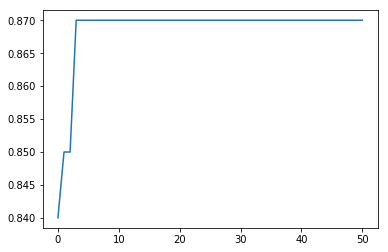

In [224]:
bestFitnesses = [0.8399999737739563,
 0.85000002384185791,
 0.85000002384185791,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158,
 0.87000000476837158]
plt.plot(list(range(51)), bestFitnesses)
# plt.axis([0, 6, 0, 20])
plt.show()